# Installing dependencies:

In [2]:
!pip install tensorflow --quiet
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Defining stock selection and date range:

In [4]:
# stocks = ["AMZN", "EBAY", "BABA", "SHOP", "WMT"]
stocks = ["AMZN"]

start = "2016-01-01"
end = "2024-01-01"

# Downloading stock data:

In [6]:
stock_data = yf.download(stocks, 
                         start = start, 
                         end = end, 
                         interval = "1d",
                         progress = False)
stock_data = stock_data[["Adj Close"]].copy()
stock_data.columns = stock_data.columns.map(lambda x: f"{x[0]}_{x[1]}")
stock_data.dropna(inplace = True)
display(f"Shape is: {stock_data.shape}", 
        stock_data.head(2), 
        stock_data.tail(2))

'Shape is: (2012, 1)'

,Adj Close_AMZN
Date,
2016-01-04,31.849501
2016-01-05,31.689501


,Adj Close_AMZN
Date,
2023-12-28,153.380005
2023-12-29,151.940002


In [7]:
# for column in stock_data.columns:
#     plt.figure(figsize = (15, 6))
#     plt.plot(stock_data.index, stock_data[f"{column}"], 
#              "r-",
#              linewidth = 0.5)
#     plt.grid(color = "green", 
#              linestyle = "--", 
#              linewidth = 0.5)
#     plt.xlabel("Date")
#     plt.ylabel(f"Prices of {column.split("_")[1]}") # <- important when we have many stocks
#                                                     #     [1] when only one ticker
#     plt.tight_layout()
#     plt.show()

# Adding target variables:
In this step, we add target variables to our dataset. The target variables represent past adjusted close prices, and are defined as:
- **t3**: The adjusted close price shifted by 3 time steps
- **t2**: The adjusted close price shifted by 2 time steps
- **t1**: The adjusted close price shifted by 1 time step
- **t**: The current adjusted close price (the target variable we want to predict)
The features (t1, t2, t3) are used to predict the current stock price (**t**).

In [9]:
def add_targets(df):
    df = df.copy()
    df["t3"] = df["Adj Close_AMZN"].shift(3)
    df["t2"] = df["Adj Close_AMZN"].shift(2)
    df["t1"] = df["Adj Close_AMZN"].shift(1)
    df["t"] = df[f"{df.columns[0]}"]
    df.drop(f"{df.columns[0]}", axis = 1, inplace = True)
    df = df.dropna()
    return df

final = add_targets(stock_data)
display(final.head(5))

,t3,t2,t1,t
Date,,,,
2016-01-07,31.849501,31.689501,31.632500,30.396999
2016-01-08,31.689501,31.632500,30.396999,30.352501
2016-01-11,31.632500,30.396999,30.352501,30.886999
2016-01-12,30.396999,30.352501,30.886999,30.894501
2016-01-13,30.352501,30.886999,30.894501,29.090500


In [10]:
# for analysis of multiple stocks
# def add_targets(df):
#     for column in df.columns:
#         if column.split("_")[0] == "Adj Close":
#             df = df.copy()
#             df[f"t4 {column}"] = df[f"{column}"].shift(4)
#             df[f"t3 {column}"] = df[f"{column}"].shift(3)
#             df[f"t2 {column}"] = df[f"{column}"].shift(2)
#             df[f"t1 {column}"] = df[f"{column}"].shift(1)
#             df = df.dropna()
#     return df

# Preparing data for modeling:
This function converts the final dataframe into three components:  

- `dates`: The index converted to a NumPy array.  
- `X`: The input features, reshaped to match the LSTM format `(samples, timesteps, features)`.  
- `y`: The target variable (adjusted closing price for the current day).

In [12]:
def final_to_date_X_y(final_df):
    
  dates = final_df.index.to_numpy()  
  df_as_np = final_df.to_numpy()
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  Y = df_as_np[:, -1]
  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = final_to_date_X_y(final_df = final)
dates.shape, X.shape, y.shape

((2009,), (2009, 2, 1), (2009,))

# Splitting data into training, validation, and test sets:
The data is split into three sets:  

- **Train set** (80% of the data)  
- **Validation set** (10% of the data)  
- **Test set** (remaining 10% of the data)  

The following plot visualizes these splits.

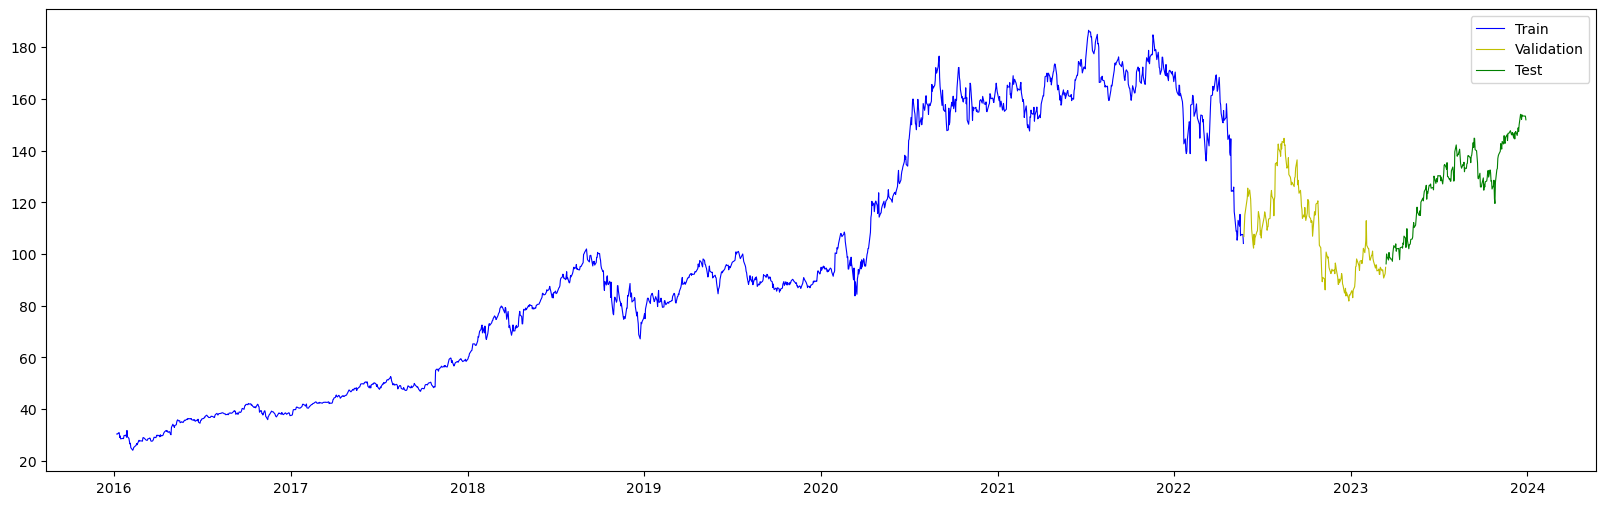

In [14]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize = (20, 6))
plt.plot(dates_train, y_train, "b-", linewidth = 0.8)
plt.plot(dates_val, y_val, "y-", linewidth = 0.8)
plt.plot(dates_test, y_test, "g-", linewidth = 0.8)
plt.legend(['Train', 'Validation', 'Test'])

# Defining and training the LSTM model:
We define the LSTM model with the following structure:  
- **Input layer**: Shape (3, 1) (3 timesteps with 1 feature)  
- **LSTM layer**: 64 units  
- **Dense layers**: Two layers with 32 units each and ReLU activation  
- **Output layer**: A single neuron for the predicted adjusted close price  

The model is compiled with **mean squared error (MSE)** as the loss function, the **Adam optimizer**, and **mean absolute error** as the evaluation metric. It is then trained for 100 epochs using the training data, with validation data for tuning.  

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = "relu"),
                    layers.Dense(32, activation = "relu"),
                    layers.Dense(1)])

model.compile(loss = "mse", 
              optimizer = Adam(learning_rate = 0.001),
              metrics = ["mean_absolute_error"])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 10978.1963 - mean_absolute_error: 93.1642 - val_loss: 10178.2256 - val_mean_absolute_error: 99.5243
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8000.2959 - mean_absolute_error: 74.2985 - val_loss: 809.8664 - val_mean_absolute_error: 23.4580
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1979.1144 - mean_absolute_error: 36.5122 - val_loss: 35.5140 - val_mean_absolute_error: 4.9064
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 126.7131 - mean_absolute_error: 6.5591 - val_loss: 11.7530 - val_mean_absolute_error: 2.6085
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3736 - mean_absolute_error: 1.8748 - val_loss: 17.4434 - val_mean_absolute_error: 3.3512
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3965 - mean_absolute_error: 1.8686 - val_loss: 19.6261 - val_mean_absolute_error: 3.4799
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.9791 - mean_absol

# Plotting training predictions
In this step, we make predictions on the training data using the model and visualize the results:  
- The **blue line** represents the **training predictions** from the model for the training set.  
- The **green line** represents the **actual training** observations.

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


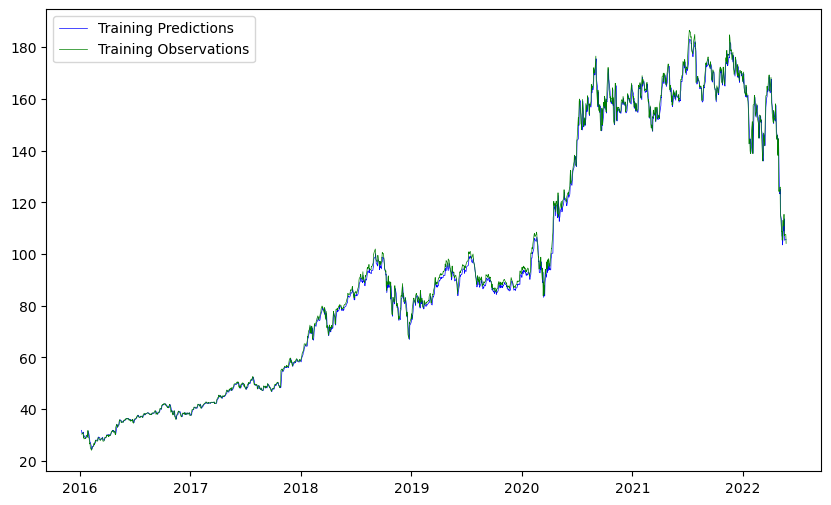

In [18]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize = (10, 6))
plt.plot(dates_train, train_predictions, "b-", linewidth = 0.5)
plt.plot(dates_train, y_train, "g-", linewidth = 0.5)
plt.legend(["Training Predictions", "Training Observations"])

# Plotting validation predictions:
In this step, we make predictions on the validation data using the model and visualize the results:
- The **line for validation predictions** represents the **predicted adjusted close prices** from the model for the **validation set**.  
- The **line for validation observations** represents the **actual adjusted close prices** for the **validation set**.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


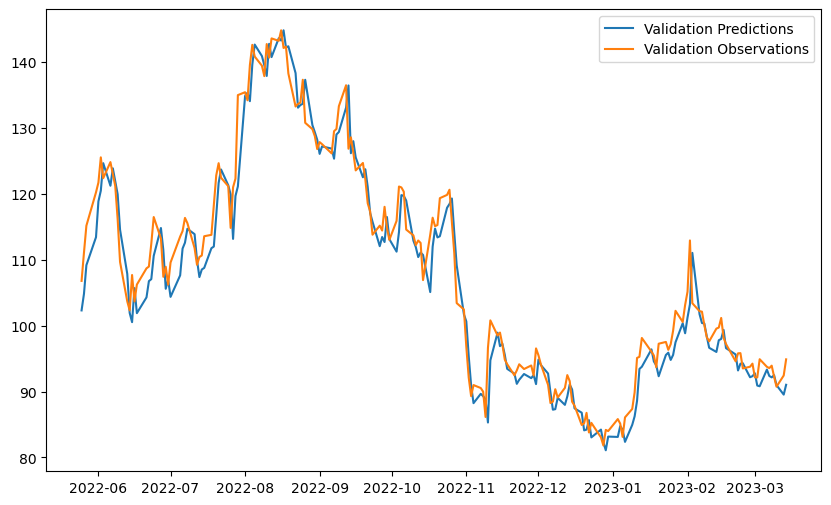

In [20]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize = (10, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(["Validation Predictions", "Validation Observations"])

# Plotting test predictions:
In this step, we make predictions on the test data using the model and visualize the results:  
- The **line for testing predictions** represents the **predicted adjusted close prices** from the model for the **test set**.  
- The **line for testing observations** represents the **actual adjusted close prices** for the **test set**.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


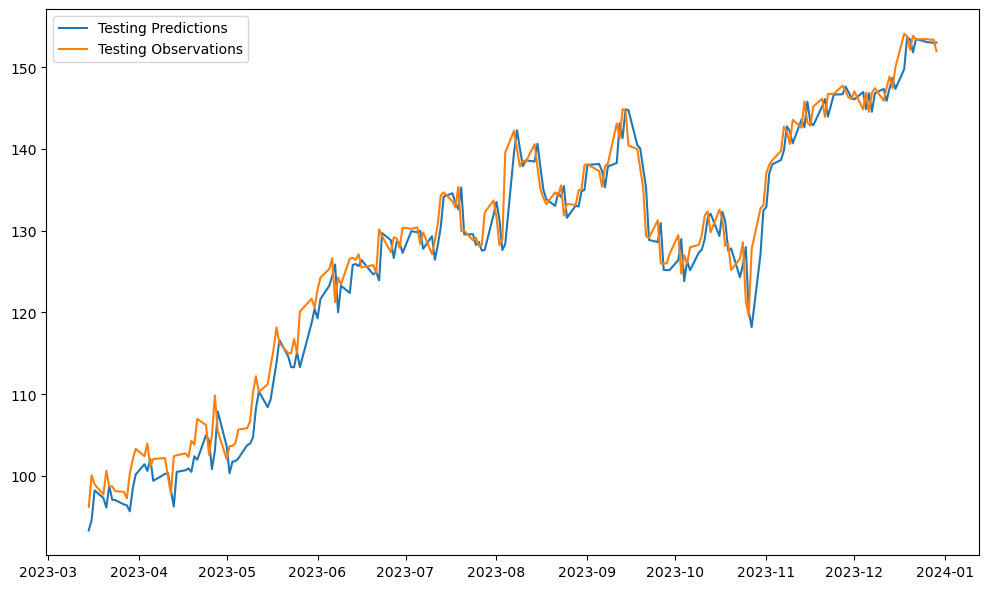

In [22]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize = (10, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.tight_layout()
plt.legend(["Testing Predictions", "Testing Observations"])